<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import cv2

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\melnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

# Add padding and resize to 224x224x3 for Vision Transformer input
for i in range(len(eeg_folds)):
    padded_images = []
    for img in eeg_folds[i]:
        padded_img = cv2.copyMakeBorder(img, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_img = cv2.resize(padded_img, (224, 224))
        padded_images.append(resized_img)
    eeg_folds[i] = np.array(padded_images, dtype=np.float16)

print(type(eeg_fold_4))
for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)
    
print(eeg_folds[1].shape)

<class 'numpy.ndarray'>
(1187, 224, 224, 3)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False


def patchify(data, n_patches):
    n, c, h, w = data.shape
    # Create tensor on the same device as input data
    patches = torch.zeros(n, n_patches**2, (c*h*w) // (n_patches**2), device=data.device)
    patch_size = h // n_patches
    for idx, d in enumerate(data):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = d[:, i*patch_size: (i+1)*patch_size, j*patch_size: (j+1) * patch_size]
                patches[idx, i*n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d, device='cpu'):
    result = torch.ones(sequence_length, d, device=device)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
class vit(nn.Module):
    def __init__(self, input_size, n_patches, hidden_size, num_classes, num_transformer_blocks=2, num_heads=4):
        super().__init__()
        self.chw = input_size
        self.n_patches = n_patches
        self.patch_size = ((self.chw[1] // n_patches) ** 2) * self.chw[0]
        
        # Core components
        self.linear_mapper = nn.Linear(self.patch_size, hidden_size)
        self.class_token = nn.Parameter(torch.rand(1, hidden_size))
        
        # Simplified positional embedding
        self.register_buffer('pos_embed', get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size))
        
        # Normalization and Transformer
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True),
            num_layers=num_transformer_blocks
        )
        
        # Classification head
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Create patches
        patches = patchify(x, self.n_patches)
        
        # Project patches to embedding dimension
        x = self.linear_mapper(patches)
        
        # Add class token
        batch_size = x.shape[0]
        cls_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.layer_norm(x)
        
        # Apply transformer
        x = self.transformer(x)
        
        # Classification based on CLS token
        x = x[:, 0]
        return self.classifier(x)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:

randomdata = torch.randn((1, 3, 224, 224))  # Adjusted to match the input shape (batch_size, channels, height, width)

# Modify the vit parameters to accommodate the shape mismatch
model = vit(input_size=(3, 224, 224), n_patches=14, hidden_size=256, num_classes=3)  # Adjusted n_patches and hidden_size
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                            Param #
vit                                                               256
├─Linear: 1-1                                                     196,864
├─LayerNorm: 1-2                                                  512
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          1,315,072
│    │    └─TransformerEncoderLayer: 3-2                          1,315,072
├─Linear: 1-4                                                     771
Total params: 2,828,547
Trainable params: 2,828,547
Non-trainable params: 0

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters: {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 4.791527211534685e-05, 'weight_decay': 2.723389186594195e-05, 'batch_size': 32, 'num_transformer_blocks': 6, 'num_heads': 8, 'accuracy': 0.434}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1101, Accuracy: 0.3472
Validation Loss: 1.0784, Validation Accuracy: 0.3699
Epoch [2/100], Loss: 1.1026, Accuracy: 0.3628
Validation Loss: 1.1296, Validation Accuracy: 0.3410
Epoch [3/100], Loss: 1.1024, Accuracy: 0.3594
Validation Loss: 1.1675, Validation Accuracy: 0.3479
Epoch [4/100], Loss: 1.0932, Accuracy: 0.3880
Validation Loss: 1.0841, Validation Accuracy: 0.3904
Epoch [5/100], Loss: 1.1032, Accuracy: 0.3681
Validation Loss: 1.1042, Validation Accuracy: 0.4448
Epoch [

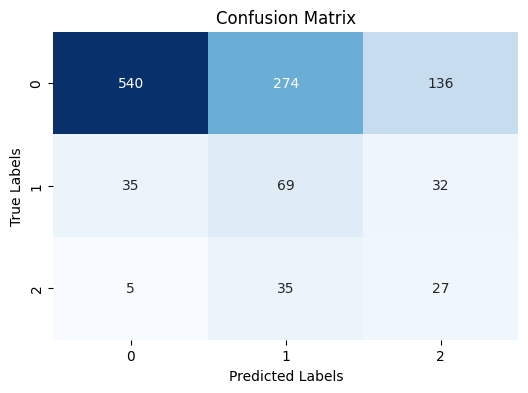


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 540/950 (56.84%)
Class 1: Correct Predictions / Total True Samples = 69/136 (50.74%)
Class 2: Correct Predictions / Total True Samples = 27/67 (40.30%)

Precision-Recall Curves:


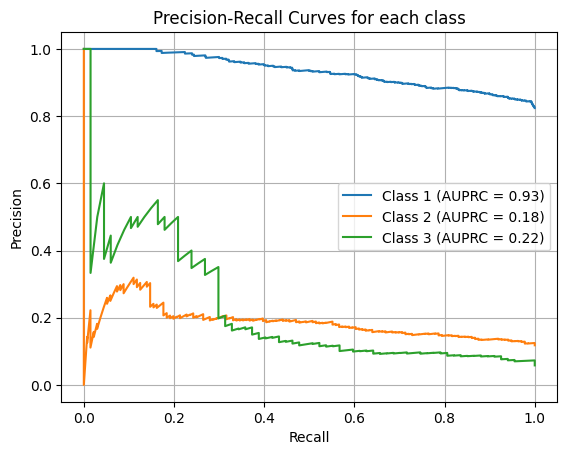


ROC Curves:


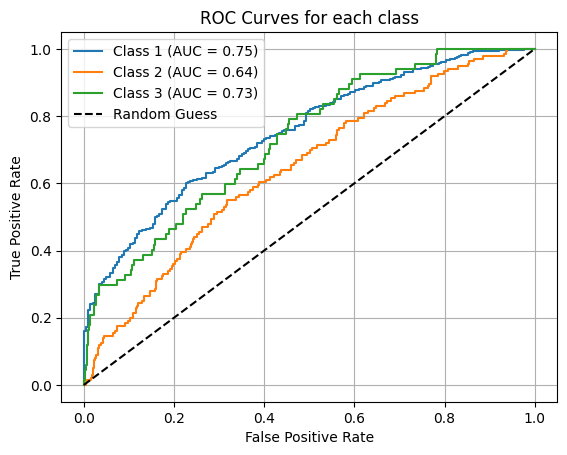


Mean F1 Score: 0.3935
Balanced Accuracy: 0.4929
Average AUPRC: 0.4445

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71       950
           1       0.18      0.51      0.27       136
           2       0.14      0.40      0.21        67

    accuracy                           0.55      1153
   macro avg       0.42      0.49      0.39      1153
weighted avg       0.80      0.55      0.63      1153

Fold No: 2
Epoch [1/100], Loss: 1.1074, Accuracy: 0.3304
Validation Loss: 1.0438, Validation Accuracy: 0.3284
Epoch [2/100], Loss: 1.0954, Accuracy: 0.3732
Validation Loss: 1.0679, Validation Accuracy: 0.3784
Epoch [3/100], Loss: 1.1004, Accuracy: 0.3614
Validation Loss: 1.1187, Validation Accuracy: 0.4254
Epoch [4/100], Loss: 1.0812, Accuracy: 0.4006
Validation Loss: 0.9406, Validation Accuracy: 0.3465
Epoch [5/100], Loss: 1.0732, Accuracy: 0.4486
Validation Loss: 0.9634, Validation Accuracy: 0.3502
Epoch [6/100], Los

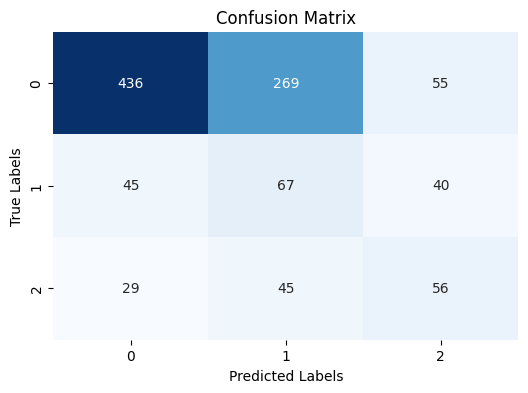


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 436/760 (57.37%)
Class 1: Correct Predictions / Total True Samples = 67/152 (44.08%)
Class 2: Correct Predictions / Total True Samples = 56/130 (43.08%)

Precision-Recall Curves:


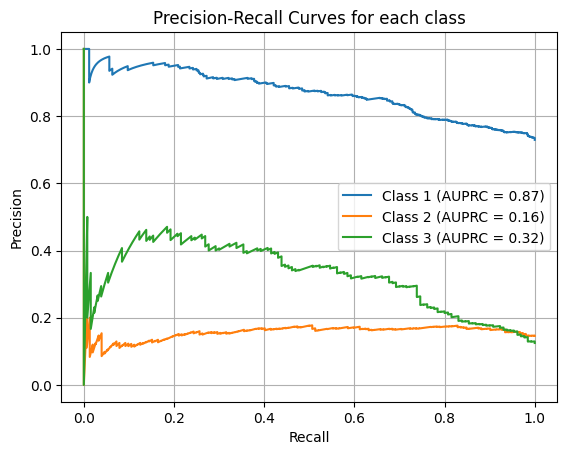


ROC Curves:


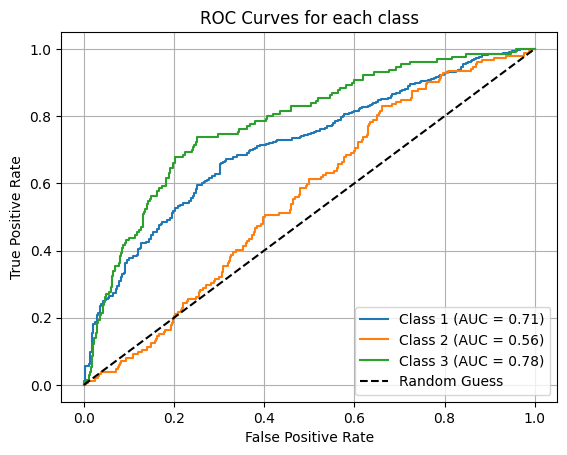


Mean F1 Score: 0.4455
Balanced Accuracy: 0.4817
Average AUPRC: 0.4487

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.57      0.69       760
           1       0.18      0.44      0.25       152
           2       0.37      0.43      0.40       130

    accuracy                           0.54      1042
   macro avg       0.47      0.48      0.45      1042
weighted avg       0.70      0.54      0.59      1042

Fold No: 3
Epoch [1/100], Loss: 1.1061, Accuracy: 0.3545
Validation Loss: 1.2621, Validation Accuracy: 0.3410
Epoch [2/100], Loss: 1.0921, Accuracy: 0.3808
Validation Loss: 1.0788, Validation Accuracy: 0.3937
Epoch [3/100], Loss: 1.0773, Accuracy: 0.4385
Validation Loss: 0.9512, Validation Accuracy: 0.3329
Epoch [4/100], Loss: 1.0608, Accuracy: 0.4724
Validation Loss: 1.1302, Validation Accuracy: 0.3412
Epoch [5/100], Loss: 1.0626, Accuracy: 0.4597
Validation Loss: 1.1380, Validation Accuracy: 0.4045
Epoch [6/100], Los

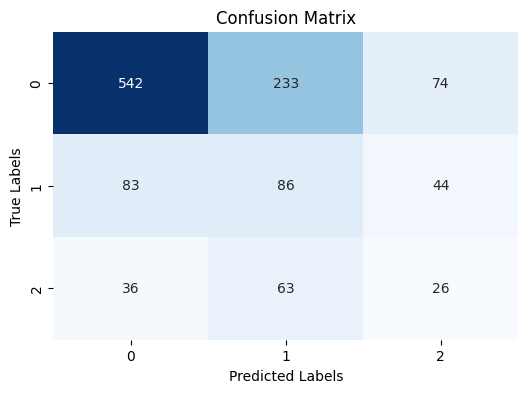


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 542/849 (63.84%)
Class 1: Correct Predictions / Total True Samples = 86/213 (40.38%)
Class 2: Correct Predictions / Total True Samples = 26/125 (20.80%)

Precision-Recall Curves:


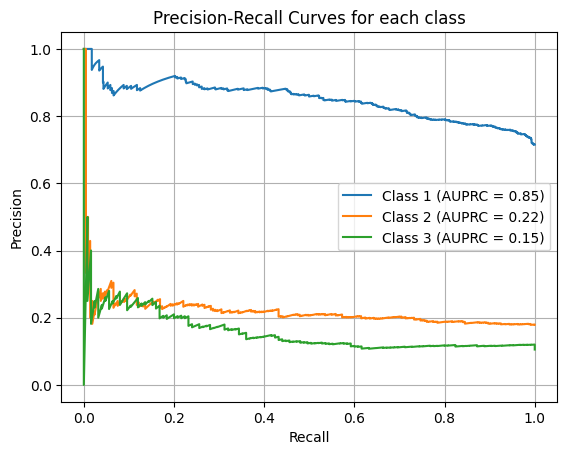


ROC Curves:


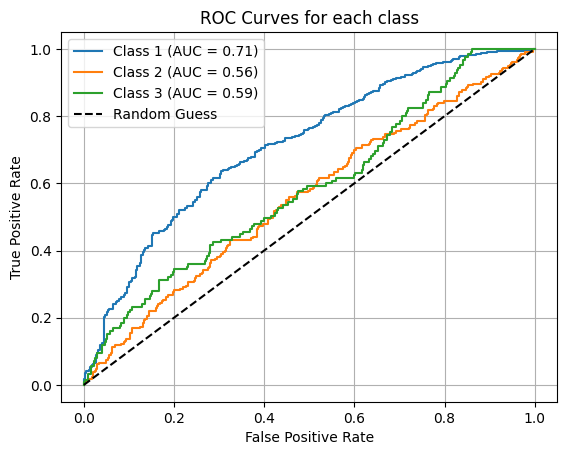


Mean F1 Score: 0.4001
Balanced Accuracy: 0.4167
Average AUPRC: 0.4064

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       849
           1       0.23      0.40      0.29       213
           2       0.18      0.21      0.19       125

    accuracy                           0.55      1187
   macro avg       0.41      0.42      0.40      1187
weighted avg       0.65      0.55      0.59      1187

Fold No: 4
Epoch [1/100], Loss: 1.1213, Accuracy: 0.3190
Validation Loss: 1.1412, Validation Accuracy: 0.2966
Epoch [2/100], Loss: 1.1022, Accuracy: 0.3646
Validation Loss: 1.1523, Validation Accuracy: 0.3380
Epoch [3/100], Loss: 1.0942, Accuracy: 0.3892
Validation Loss: 1.0315, Validation Accuracy: 0.2943
Epoch [4/100], Loss: 1.0958, Accuracy: 0.3756
Validation Loss: 1.2233, Validation Accuracy: 0.2924
Epoch [5/100], Loss: 1.0817, Accuracy: 0.4162
Validation Loss: 1.1355, Validation Accuracy: 0.3557
Epoch [6/100], Los

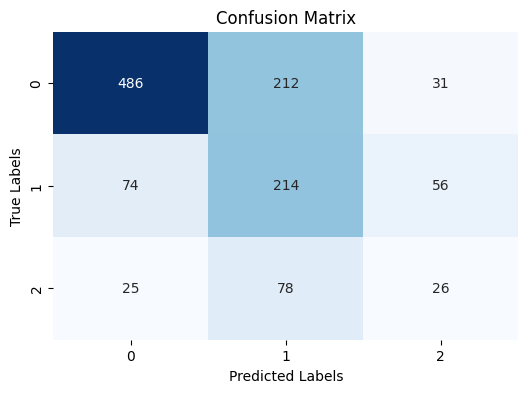


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 486/729 (66.67%)
Class 1: Correct Predictions / Total True Samples = 214/344 (62.21%)
Class 2: Correct Predictions / Total True Samples = 26/129 (20.16%)

Precision-Recall Curves:


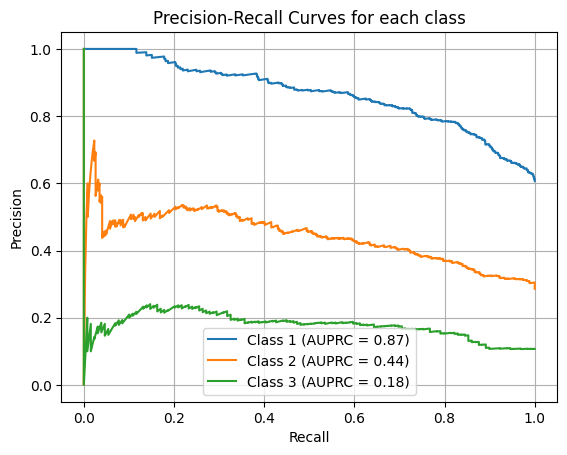


ROC Curves:


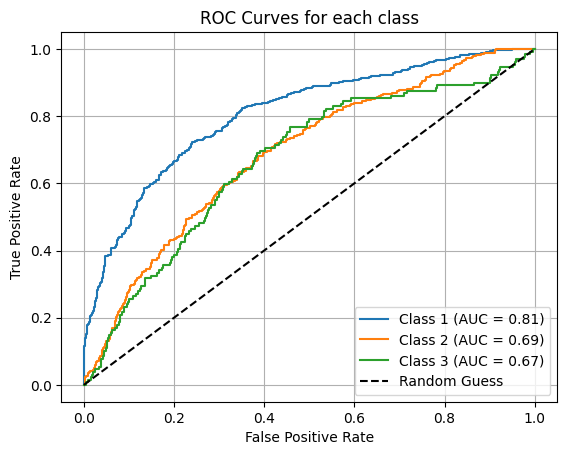


Mean F1 Score: 0.4864
Balanced Accuracy: 0.4968
Average AUPRC: 0.4945

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       729
           1       0.42      0.62      0.50       344
           2       0.23      0.20      0.21       129

    accuracy                           0.60      1202
   macro avg       0.50      0.50      0.49      1202
weighted avg       0.65      0.60      0.62      1202

Fold No: 5
Epoch [1/100], Loss: 1.1118, Accuracy: 0.3561
Validation Loss: 1.0895, Validation Accuracy: 0.3411
Epoch [2/100], Loss: 1.1060, Accuracy: 0.3427
Validation Loss: 1.1277, Validation Accuracy: 0.3837
Epoch [3/100], Loss: 1.1070, Accuracy: 0.3333
Validation Loss: 1.0834, Validation Accuracy: 0.3603
Epoch [4/100], Loss: 1.1043, Accuracy: 0.3354
Validation Loss: 1.0294, Validation Accuracy: 0.3298
Epoch [5/100], Loss: 1.0979, Accuracy: 0.3540
Validation Loss: 1.1055, Validation Accuracy: 0.3841
Epoch [6/100], Los

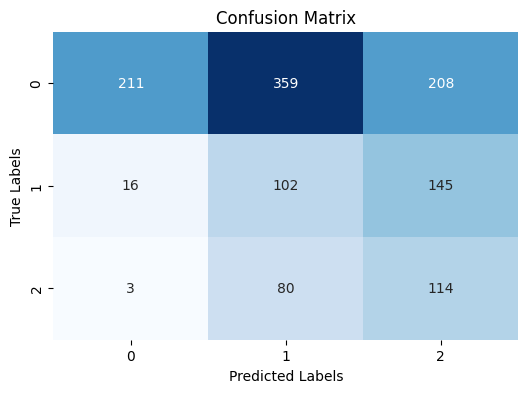


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 211/778 (27.12%)
Class 1: Correct Predictions / Total True Samples = 102/263 (38.78%)
Class 2: Correct Predictions / Total True Samples = 114/197 (57.87%)

Precision-Recall Curves:


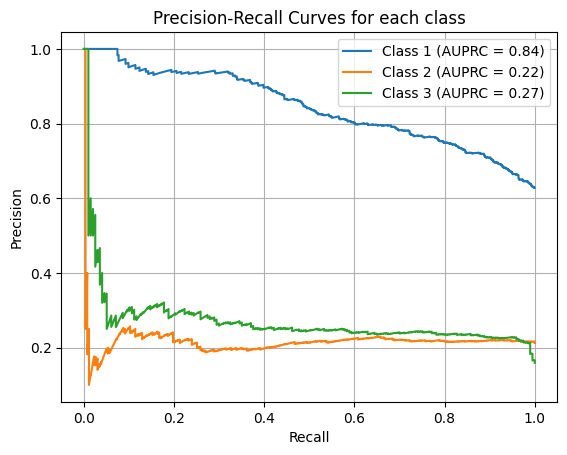


ROC Curves:


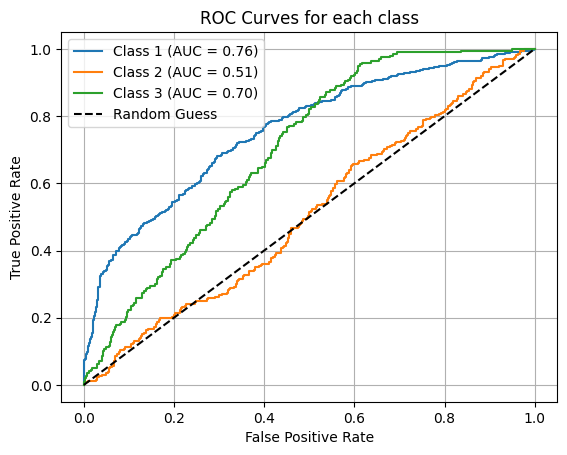


Mean F1 Score: 0.3386
Balanced Accuracy: 0.4126
Average AUPRC: 0.4434

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.27      0.42       778
           1       0.19      0.39      0.25       263
           2       0.24      0.58      0.34       197

    accuracy                           0.34      1238
   macro avg       0.45      0.41      0.34      1238
weighted avg       0.66      0.34      0.37      1238

Accuracy for each fold: [np.float64(0.49291968947830506), np.float64(0.4817476383265857), np.float64(0.4167179946581728), np.float64(0.4967700258397933), np.float64(0.4125737096288456)]
AUPRC for each fold: [np.float64(0.4444863744583638), np.float64(0.44867285141028446), np.float64(0.406392732575634), np.float64(0.49447705680896603), np.float64(0.44340434417290137)]
Average AUPRC across all folds: 0.4474866718852299
Average Balanced Accuracy across all folds: 0.4601458115863405
________________________________________

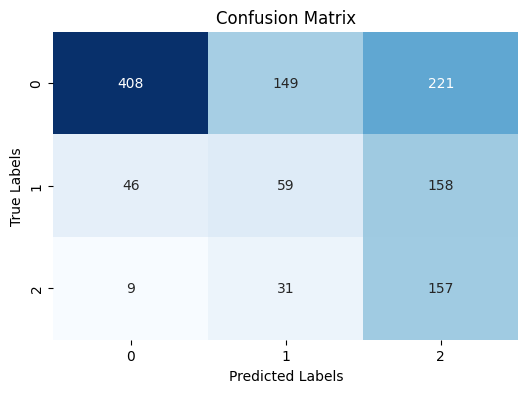


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 408/778 (52.44%)
Class 1: Correct Predictions / Total True Samples = 59/263 (22.43%)
Class 2: Correct Predictions / Total True Samples = 157/197 (79.70%)

Precision-Recall Curves:


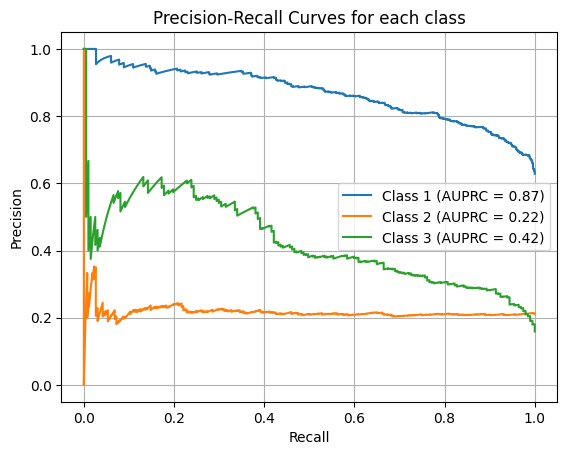


ROC Curves:


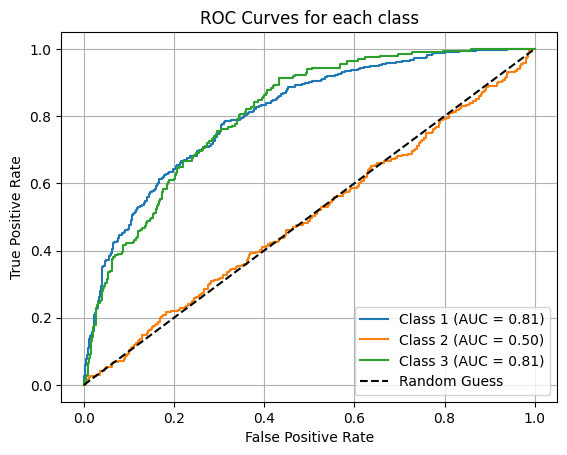


Mean F1 Score: 0.4403
Balanced Accuracy: 0.5152
Average AUPRC: 0.5018

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.52      0.66       778
           1       0.25      0.22      0.24       263
           2       0.29      0.80      0.43       197

    accuracy                           0.50      1238
   macro avg       0.47      0.52      0.44      1238
weighted avg       0.65      0.50      0.53      1238

Fold No: 2
Epoch [1/100], Loss: 1.1131, Accuracy: 0.3499
Validation Loss: 1.1969, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1124, Accuracy: 0.3375
Validation Loss: 1.1310, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1036, Accuracy: 0.3540
Validation Loss: 1.1106, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1032, Accuracy: 0.3613
Validation Loss: 1.0810, Validation Accuracy: 0.3399
Epoch [5/100], Loss: 1.1053, Accuracy: 0.3261
Validation Loss: 1.0981, Validation Accuracy: 0.3703
Epoch [6/100], Los

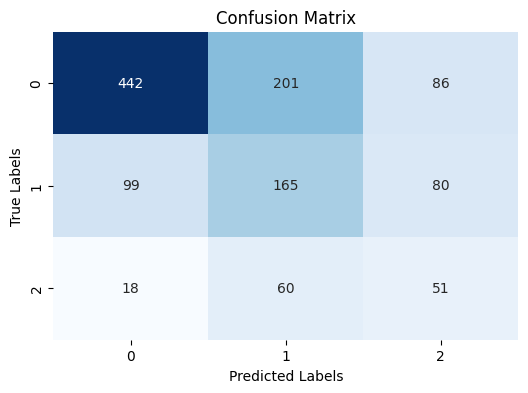


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 442/729 (60.63%)
Class 1: Correct Predictions / Total True Samples = 165/344 (47.97%)
Class 2: Correct Predictions / Total True Samples = 51/129 (39.53%)

Precision-Recall Curves:


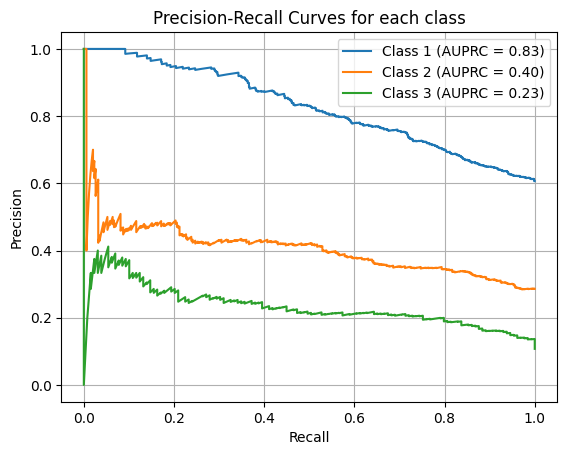


ROC Curves:


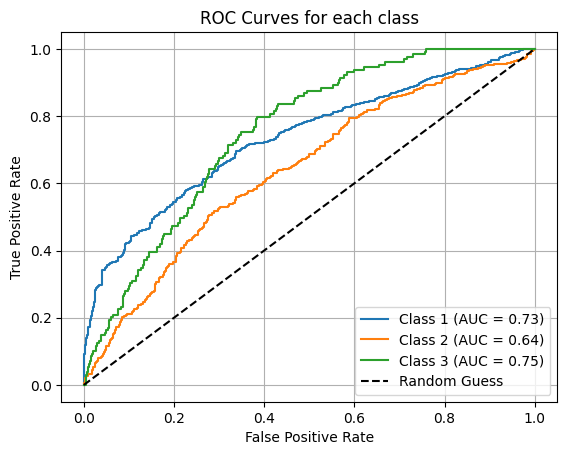


Mean F1 Score: 0.4699
Balanced Accuracy: 0.4938
Average AUPRC: 0.4871

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       729
           1       0.39      0.48      0.43       344
           2       0.24      0.40      0.29       129

    accuracy                           0.55      1202
   macro avg       0.47      0.49      0.47      1202
weighted avg       0.62      0.55      0.57      1202

Fold No: 3
Epoch [1/100], Loss: 1.1163, Accuracy: 0.3291
Validation Loss: 1.1108, Validation Accuracy: 0.3429
Epoch [2/100], Loss: 1.1090, Accuracy: 0.3469
Validation Loss: 1.1182, Validation Accuracy: 0.3744
Epoch [3/100], Loss: 1.1003, Accuracy: 0.3680
Validation Loss: 1.0984, Validation Accuracy: 0.4200
Epoch [4/100], Loss: 1.0957, Accuracy: 0.3596
Validation Loss: 1.1600, Validation Accuracy: 0.3610
Epoch [5/100], Loss: 1.0911, Accuracy: 0.3773
Validation Loss: 1.0821, Validation Accuracy: 0.4244
Epoch [6/100], Los

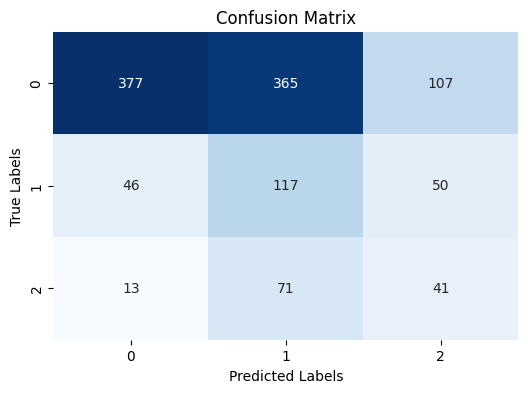


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 377/849 (44.41%)
Class 1: Correct Predictions / Total True Samples = 117/213 (54.93%)
Class 2: Correct Predictions / Total True Samples = 41/125 (32.80%)

Precision-Recall Curves:


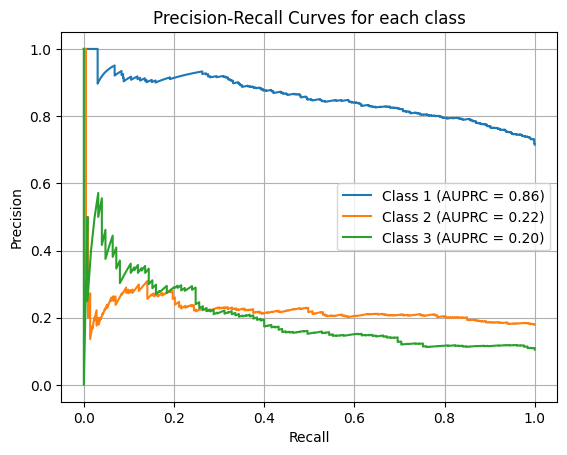


ROC Curves:


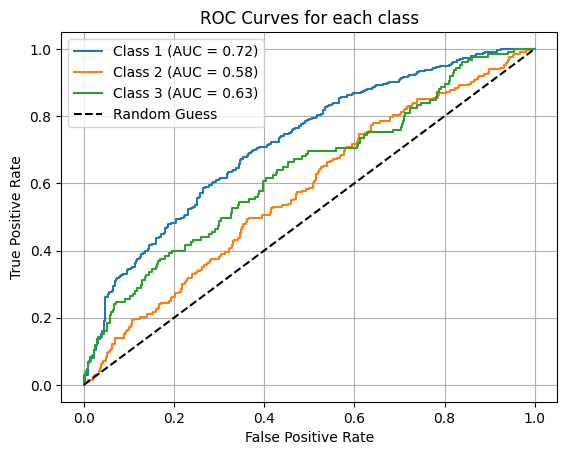


Mean F1 Score: 0.3820
Balanced Accuracy: 0.4404
Average AUPRC: 0.4259

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.44      0.59       849
           1       0.21      0.55      0.31       213
           2       0.21      0.33      0.25       125

    accuracy                           0.45      1187
   macro avg       0.43      0.44      0.38      1187
weighted avg       0.68      0.45      0.50      1187

Fold No: 4
Epoch [1/100], Loss: 1.1128, Accuracy: 0.3393
Validation Loss: 1.0975, Validation Accuracy: 0.3629
Epoch [2/100], Loss: 1.1087, Accuracy: 0.3571
Validation Loss: 1.0548, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.0986, Accuracy: 0.3630
Validation Loss: 1.1101, Validation Accuracy: 0.2824
Epoch [4/100], Loss: 1.0890, Accuracy: 0.3876
Validation Loss: 1.1090, Validation Accuracy: 0.3143
Epoch [5/100], Loss: 1.1024, Accuracy: 0.3715
Validation Loss: 1.1363, Validation Accuracy: 0.3400
Epoch [6/100], Los

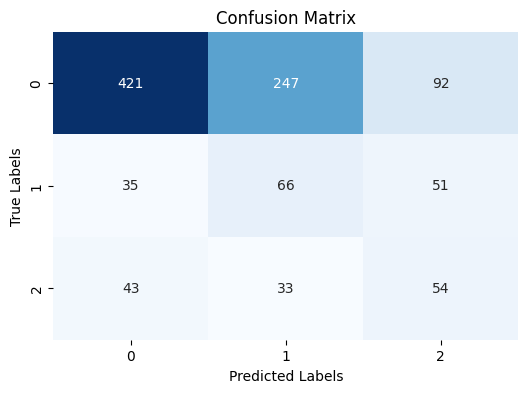


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 421/760 (55.39%)
Class 1: Correct Predictions / Total True Samples = 66/152 (43.42%)
Class 2: Correct Predictions / Total True Samples = 54/130 (41.54%)

Precision-Recall Curves:


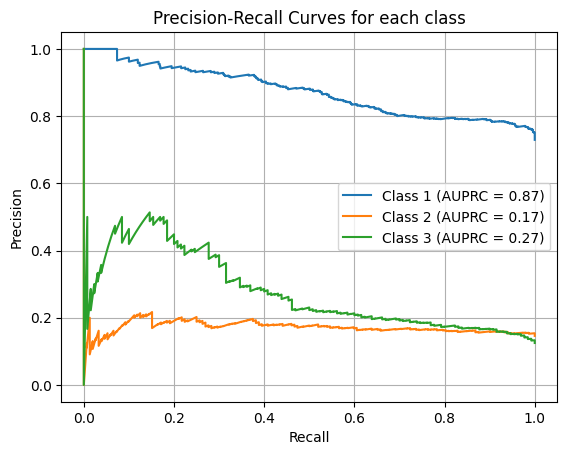


ROC Curves:


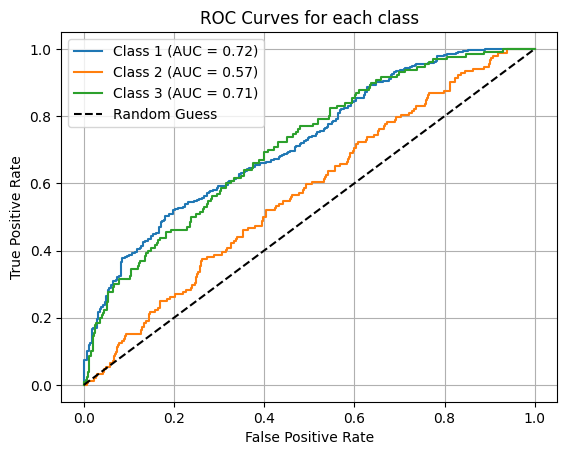


Mean F1 Score: 0.4214
Balanced Accuracy: 0.4678
Average AUPRC: 0.4387

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.55      0.67       760
           1       0.19      0.43      0.27       152
           2       0.27      0.42      0.33       130

    accuracy                           0.52      1042
   macro avg       0.44      0.47      0.42      1042
weighted avg       0.68      0.52      0.57      1042

Fold No: 5
Epoch [1/100], Loss: 1.1160, Accuracy: 0.3215
Validation Loss: 1.0865, Validation Accuracy: 0.3263
Epoch [2/100], Loss: 1.1041, Accuracy: 0.3481
Validation Loss: 1.0849, Validation Accuracy: 0.4215
Epoch [3/100], Loss: 1.0977, Accuracy: 0.3636
Validation Loss: 1.1242, Validation Accuracy: 0.4086
Epoch [4/100], Loss: 1.0987, Accuracy: 0.3407
Validation Loss: 1.0665, Validation Accuracy: 0.3978
Epoch [5/100], Loss: 1.0928, Accuracy: 0.3659
Validation Loss: 1.0622, Validation Accuracy: 0.3918
Epoch [6/100], Los

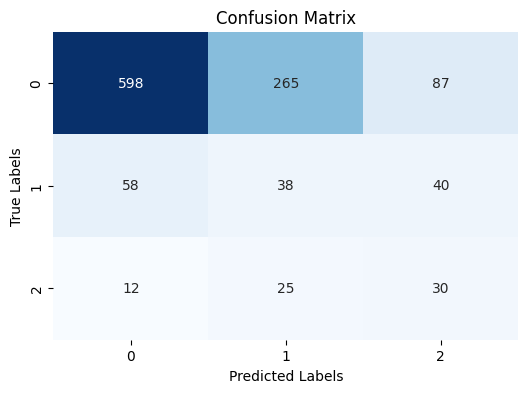


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 598/950 (62.95%)
Class 1: Correct Predictions / Total True Samples = 38/136 (27.94%)
Class 2: Correct Predictions / Total True Samples = 30/67 (44.78%)

Precision-Recall Curves:


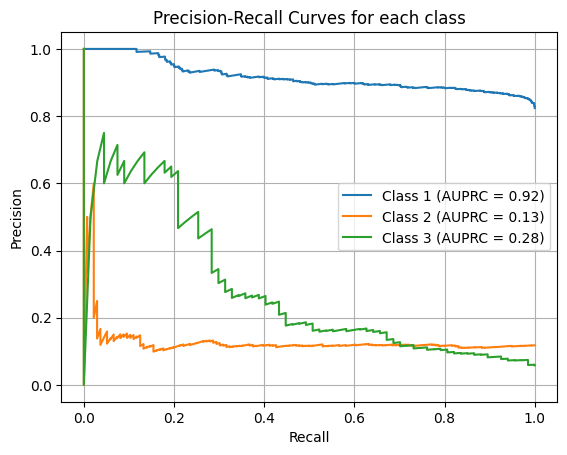


ROC Curves:


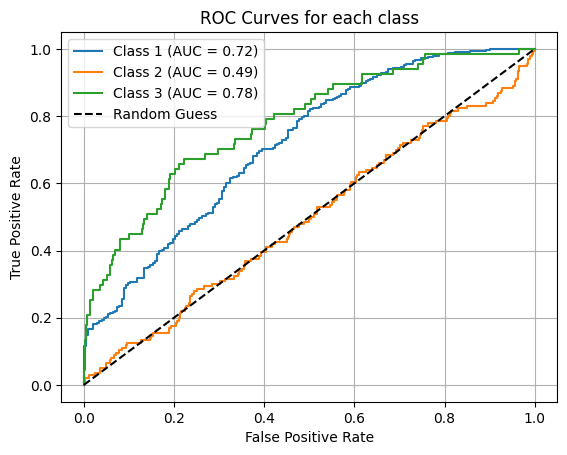


Mean F1 Score: 0.3903
Balanced Accuracy: 0.4522
Average AUPRC: 0.4400

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       950
           1       0.12      0.28      0.16       136
           2       0.19      0.45      0.27        67

    accuracy                           0.58      1153
   macro avg       0.40      0.45      0.39      1153
weighted avg       0.76      0.58      0.64      1153

Accuracy for each fold: [np.float64(0.5152368364372009), np.float64(0.4937700045724737), np.float64(0.4404492001083849), np.float64(0.4678475033738192), np.float64(0.4522155476487531)]
AUPRC for each fold: [np.float64(0.5017611875209576), np.float64(0.48712686341281924), np.float64(0.4258761038700438), np.float64(0.43865489814067044), np.float64(0.4399716398566687)]
Average AUPRC across all folds: 0.45867813856023193
Average Balanced Accuracy across all folds: 0.4739038184281264
________________________________________

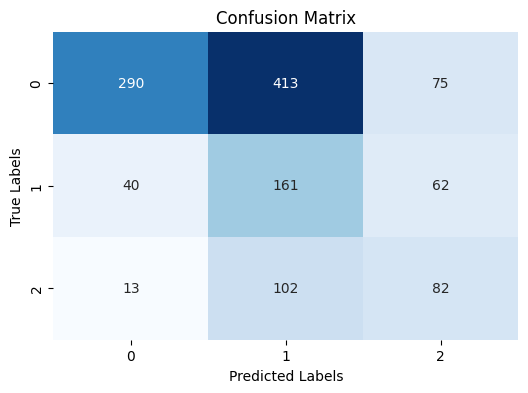


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 290/778 (37.28%)
Class 1: Correct Predictions / Total True Samples = 161/263 (61.22%)
Class 2: Correct Predictions / Total True Samples = 82/197 (41.62%)

Precision-Recall Curves:


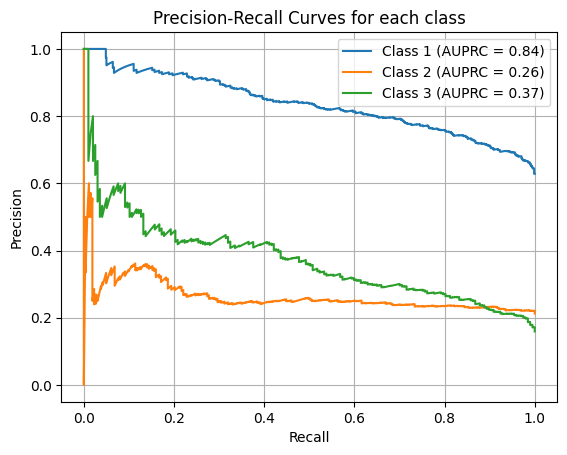


ROC Curves:


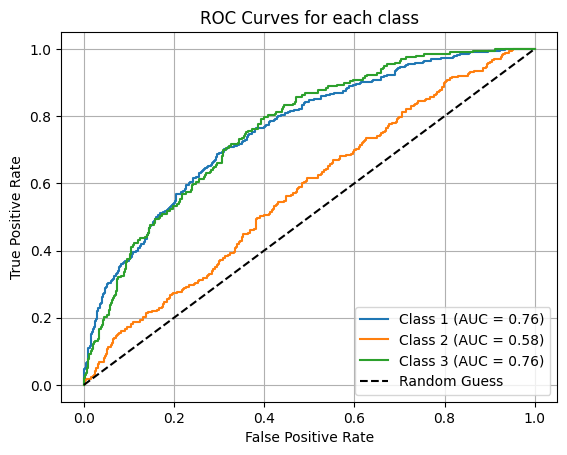


Mean F1 Score: 0.4182
Balanced Accuracy: 0.4671
Average AUPRC: 0.4896

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.37      0.52       778
           1       0.24      0.61      0.34       263
           2       0.37      0.42      0.39       197

    accuracy                           0.43      1238
   macro avg       0.49      0.47      0.42      1238
weighted avg       0.64      0.43      0.46      1238

Fold No: 2
Epoch [1/100], Loss: 1.1119, Accuracy: 0.3375
Validation Loss: 1.0729, Validation Accuracy: 0.3455
Epoch [2/100], Loss: 1.1024, Accuracy: 0.3416
Validation Loss: 1.1236, Validation Accuracy: 0.3676
Epoch [3/100], Loss: 1.0938, Accuracy: 0.3873
Validation Loss: 1.1050, Validation Accuracy: 0.3957
Epoch [4/100], Loss: 1.0791, Accuracy: 0.4060
Validation Loss: 1.0026, Validation Accuracy: 0.3420
Epoch [5/100], Loss: 1.0756, Accuracy: 0.4403
Validation Loss: 1.0491, Validation Accuracy: 0.4059
Epoch [6/100], Los

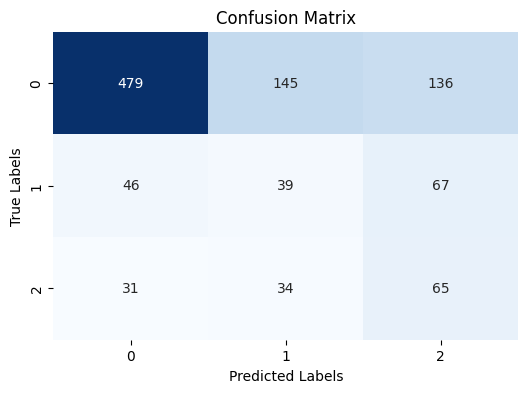


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 479/760 (63.03%)
Class 1: Correct Predictions / Total True Samples = 39/152 (25.66%)
Class 2: Correct Predictions / Total True Samples = 65/130 (50.00%)

Precision-Recall Curves:


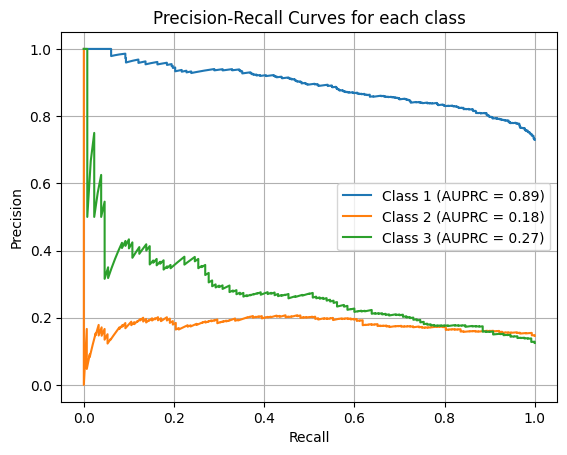


ROC Curves:


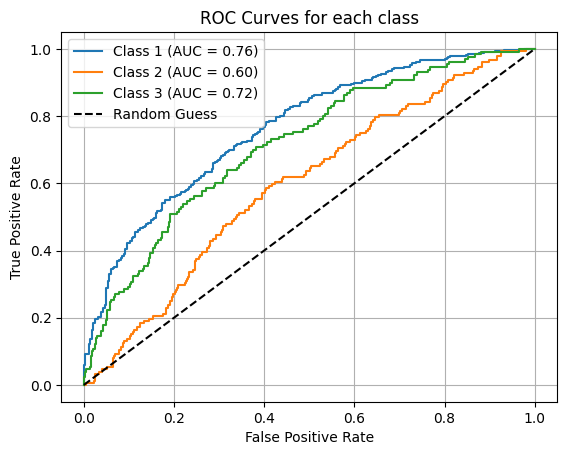


Mean F1 Score: 0.4218
Balanced Accuracy: 0.4623
Average AUPRC: 0.4479

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       760
           1       0.18      0.26      0.21       152
           2       0.24      0.50      0.33       130

    accuracy                           0.56      1042
   macro avg       0.43      0.46      0.42      1042
weighted avg       0.68      0.56      0.60      1042

Fold No: 3
Epoch [1/100], Loss: 1.1097, Accuracy: 0.3237
Validation Loss: 1.1265, Validation Accuracy: 0.3952
Epoch [2/100], Loss: 1.1021, Accuracy: 0.3525
Validation Loss: 1.0915, Validation Accuracy: 0.3565
Epoch [3/100], Loss: 1.1029, Accuracy: 0.3577
Validation Loss: 1.1691, Validation Accuracy: 0.3408
Epoch [4/100], Loss: 1.0970, Accuracy: 0.3725
Validation Loss: 1.1410, Validation Accuracy: 0.3959
Epoch [5/100], Loss: 1.0881, Accuracy: 0.3865
Validation Loss: 1.0765, Validation Accuracy: 0.3876
Epoch [6/100], Los

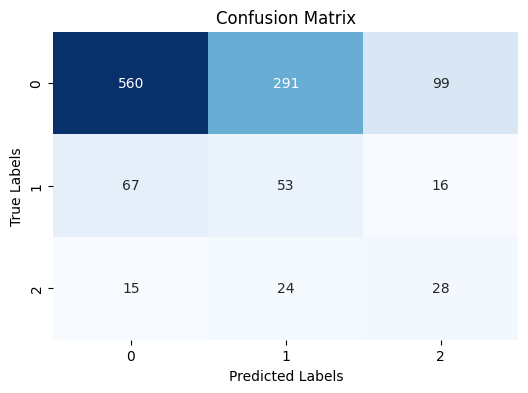


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 560/950 (58.95%)
Class 1: Correct Predictions / Total True Samples = 53/136 (38.97%)
Class 2: Correct Predictions / Total True Samples = 28/67 (41.79%)

Precision-Recall Curves:


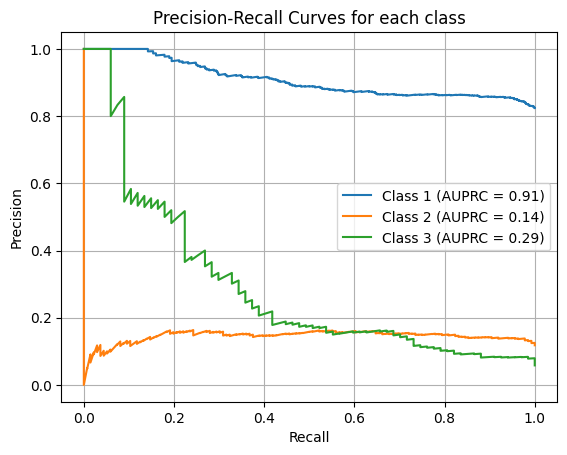


ROC Curves:


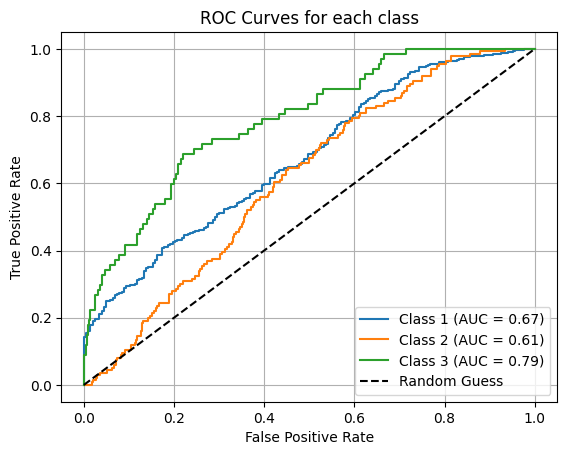


Mean F1 Score: 0.3935
Balanced Accuracy: 0.4657
Average AUPRC: 0.4479

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.59      0.70       950
           1       0.14      0.39      0.21       136
           2       0.20      0.42      0.27        67

    accuracy                           0.56      1153
   macro avg       0.40      0.47      0.39      1153
weighted avg       0.75      0.56      0.62      1153

Fold No: 4
Epoch [1/100], Loss: 1.1042, Accuracy: 0.3648
Validation Loss: 1.0398, Validation Accuracy: 0.3583
Epoch [2/100], Loss: 1.0840, Accuracy: 0.4050
Validation Loss: 1.1374, Validation Accuracy: 0.4084
Epoch [3/100], Loss: 1.0810, Accuracy: 0.4225
Validation Loss: 1.1539, Validation Accuracy: 0.4228
Epoch [4/100], Loss: 1.0673, Accuracy: 0.4401
Validation Loss: 0.9786, Validation Accuracy: 0.3674
Epoch [5/100], Loss: 1.0540, Accuracy: 0.4795
Validation Loss: 1.1044, Validation Accuracy: 0.4856
Epoch [6/100], Los

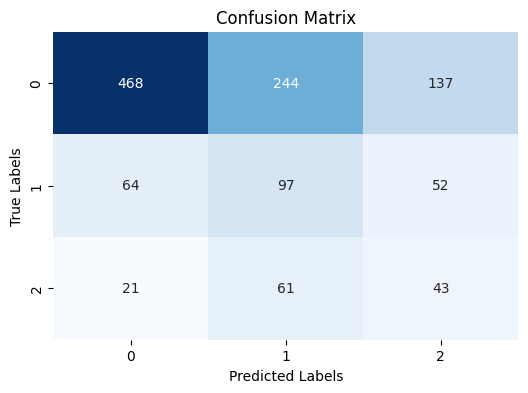


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 468/849 (55.12%)
Class 1: Correct Predictions / Total True Samples = 97/213 (45.54%)
Class 2: Correct Predictions / Total True Samples = 43/125 (34.40%)

Precision-Recall Curves:


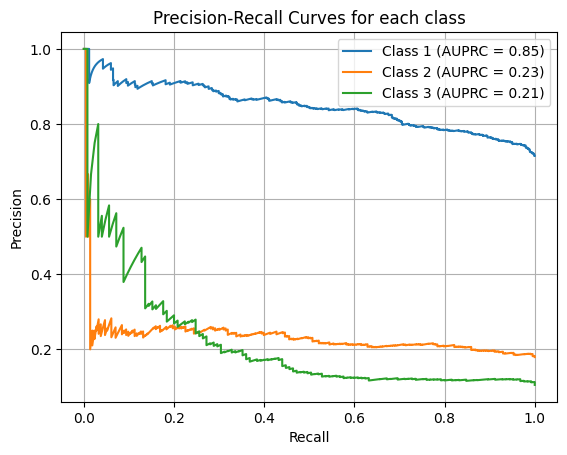


ROC Curves:


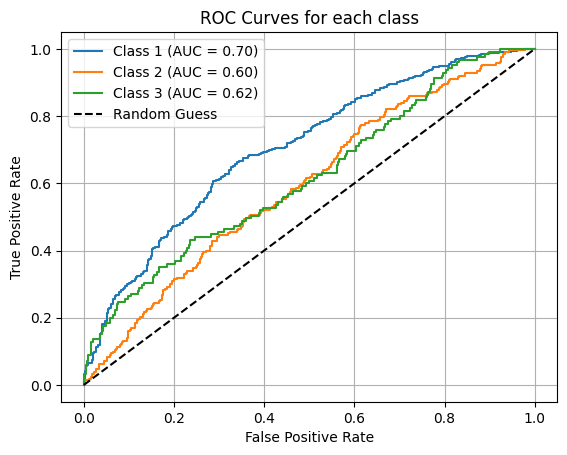


Mean F1 Score: 0.4080
Balanced Accuracy: 0.4502
Average AUPRC: 0.4311

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.55      0.67       849
           1       0.24      0.46      0.32       213
           2       0.19      0.34      0.24       125

    accuracy                           0.51      1187
   macro avg       0.42      0.45      0.41      1187
weighted avg       0.67      0.51      0.56      1187

Fold No: 5
Epoch [1/100], Loss: 1.1171, Accuracy: 0.3393
Validation Loss: 1.1849, Validation Accuracy: 0.3044
Epoch [2/100], Loss: 1.1001, Accuracy: 0.3663
Validation Loss: 1.1765, Validation Accuracy: 0.2654
Epoch [3/100], Loss: 1.0975, Accuracy: 0.3723
Validation Loss: 1.0430, Validation Accuracy: 0.3086
Epoch [4/100], Loss: 1.0894, Accuracy: 0.4078
Validation Loss: 1.0389, Validation Accuracy: 0.3160
Epoch [5/100], Loss: 1.0829, Accuracy: 0.4061
Validation Loss: 1.1872, Validation Accuracy: 0.3840
Epoch [6/100], Los

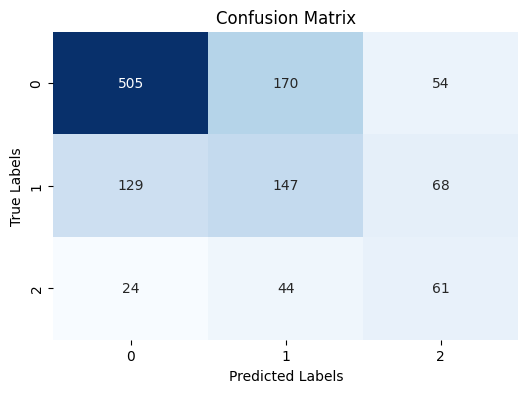


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 505/729 (69.27%)
Class 1: Correct Predictions / Total True Samples = 147/344 (42.73%)
Class 2: Correct Predictions / Total True Samples = 61/129 (47.29%)

Precision-Recall Curves:


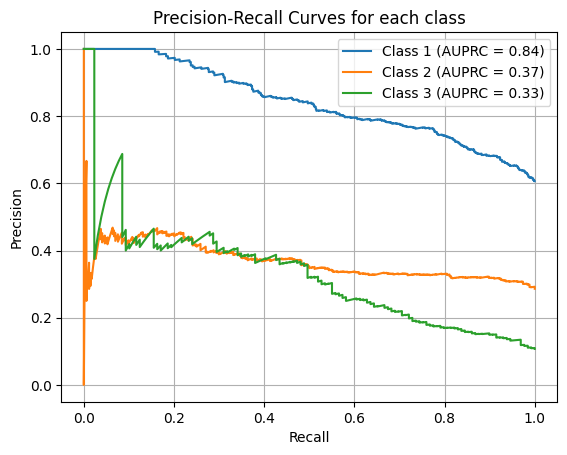


ROC Curves:


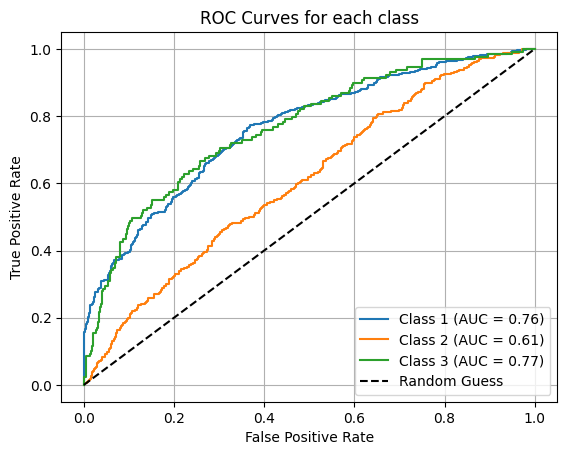


Mean F1 Score: 0.5121
Balanced Accuracy: 0.5310
Average AUPRC: 0.5111

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       729
           1       0.41      0.43      0.42       344
           2       0.33      0.47      0.39       129

    accuracy                           0.59      1202
   macro avg       0.50      0.53      0.51      1202
weighted avg       0.62      0.59      0.60      1202

Accuracy for each fold: [np.float64(0.4670538659586951), np.float64(0.46228070175438596), np.float64(0.4656966714415538), np.float64(0.4502119367164905), np.float64(0.5309745217511511)]
AUPRC for each fold: [np.float64(0.4896113830040745), np.float64(0.44794321917518004), np.float64(0.4478720344702696), np.float64(0.43106739099759417), np.float64(0.5110570971619169)]
Average AUPRC across all folds: 0.46551022496180705
Average Balanced Accuracy across all folds: 0.4752435395244553
_______________________________________

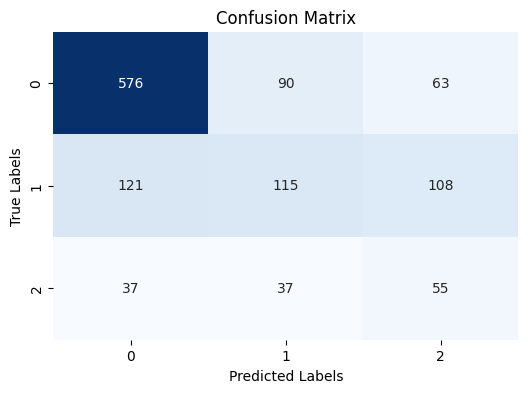


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 576/729 (79.01%)
Class 1: Correct Predictions / Total True Samples = 115/344 (33.43%)
Class 2: Correct Predictions / Total True Samples = 55/129 (42.64%)

Precision-Recall Curves:


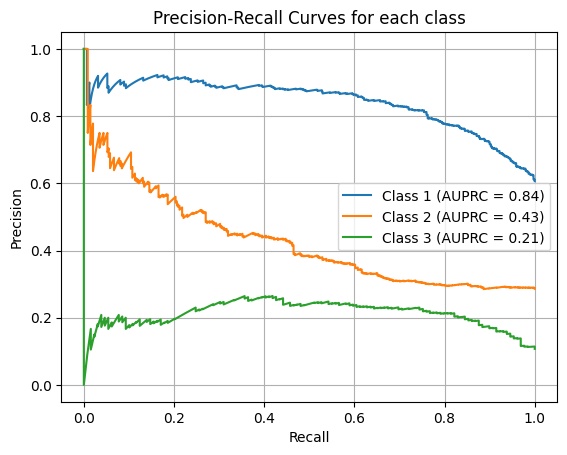


ROC Curves:


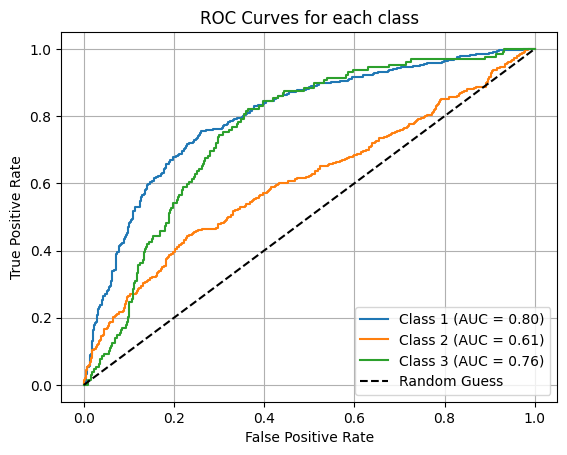


Mean F1 Score: 0.4966
Balanced Accuracy: 0.5169
Average AUPRC: 0.4935

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       729
           1       0.48      0.33      0.39       344
           2       0.24      0.43      0.31       129

    accuracy                           0.62      1202
   macro avg       0.50      0.52      0.50      1202
weighted avg       0.64      0.62      0.62      1202

Fold No: 2
Epoch [1/100], Loss: 1.1405, Accuracy: 0.3520
Validation Loss: 1.0973, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1196, Accuracy: 0.3685
Validation Loss: 1.0486, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1104, Accuracy: 0.3427
Validation Loss: 1.0907, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1131, Accuracy: 0.3747
Validation Loss: 1.1998, Validation Accuracy: 0.3516
Epoch [5/100], Loss: 1.0939, Accuracy: 0.3923
Validation Loss: 0.9697, Validation Accuracy: 0.3432
Epoch [6/100], Los

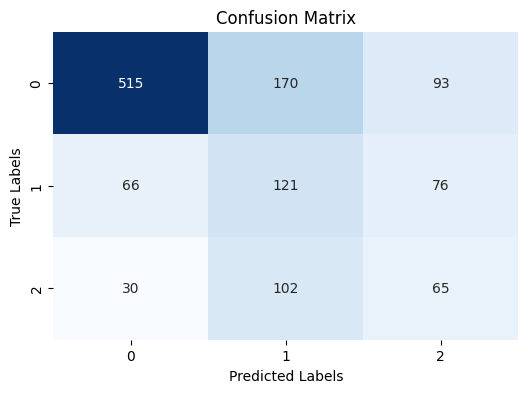


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 515/778 (66.20%)
Class 1: Correct Predictions / Total True Samples = 121/263 (46.01%)
Class 2: Correct Predictions / Total True Samples = 65/197 (32.99%)

Precision-Recall Curves:


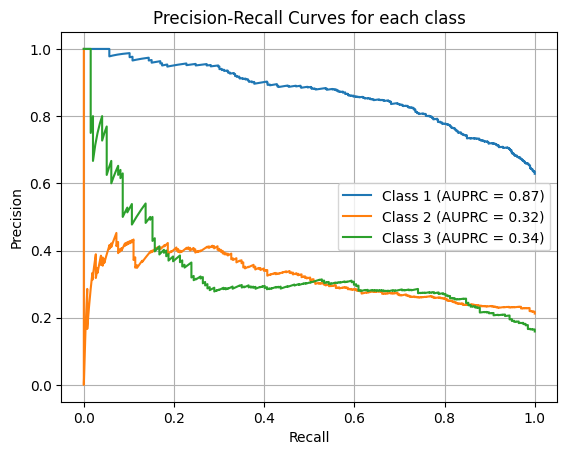


ROC Curves:


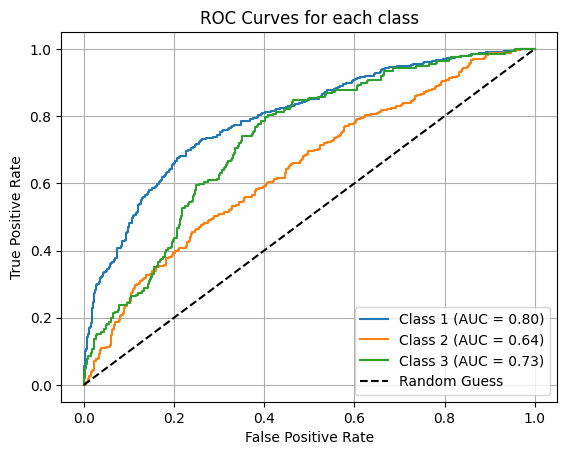


Mean F1 Score: 0.4707
Balanced Accuracy: 0.4840
Average AUPRC: 0.5073

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       778
           1       0.31      0.46      0.37       263
           2       0.28      0.33      0.30       197

    accuracy                           0.57      1238
   macro avg       0.48      0.48      0.47      1238
weighted avg       0.64      0.57      0.59      1238

Fold No: 3
Epoch [1/100], Loss: 1.1410, Accuracy: 0.3292
Validation Loss: 1.0321, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1014, Accuracy: 0.4029
Validation Loss: 1.0618, Validation Accuracy: 0.4826
Epoch [3/100], Loss: 1.0721, Accuracy: 0.4714
Validation Loss: 1.0992, Validation Accuracy: 0.4673
Epoch [4/100], Loss: 1.0600, Accuracy: 0.4818
Validation Loss: 1.0063, Validation Accuracy: 0.4835
Epoch [5/100], Loss: 1.0685, Accuracy: 0.4663
Validation Loss: 1.1290, Validation Accuracy: 0.5049
Epoch [6/100], Los

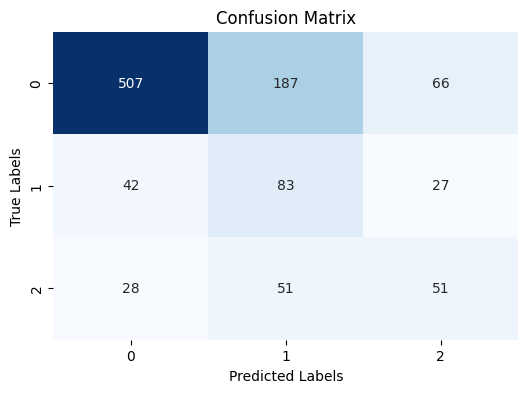


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 507/760 (66.71%)
Class 1: Correct Predictions / Total True Samples = 83/152 (54.61%)
Class 2: Correct Predictions / Total True Samples = 51/130 (39.23%)

Precision-Recall Curves:


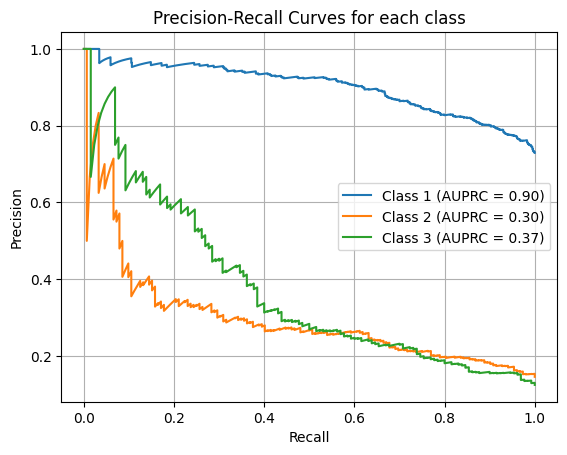


ROC Curves:


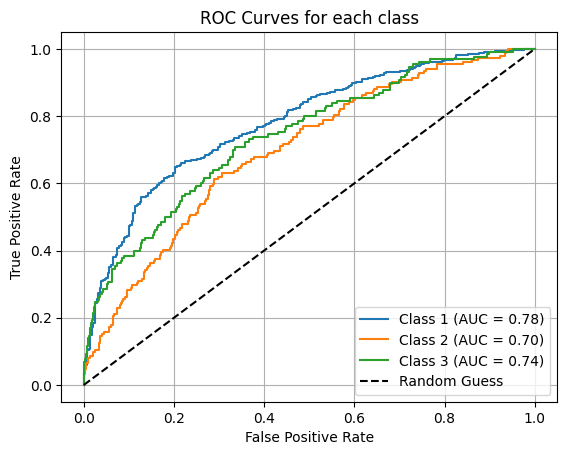


Mean F1 Score: 0.4939
Balanced Accuracy: 0.5352
Average AUPRC: 0.5230

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       760
           1       0.26      0.55      0.35       152
           2       0.35      0.39      0.37       130

    accuracy                           0.62      1042
   macro avg       0.50      0.54      0.49      1042
weighted avg       0.72      0.62      0.65      1042

Fold No: 4
Epoch [1/100], Loss: 1.1267, Accuracy: 0.3410
Validation Loss: 1.1382, Validation Accuracy: 0.3760
Epoch [2/100], Loss: 1.0977, Accuracy: 0.3622
Validation Loss: 1.4046, Validation Accuracy: 0.4119
Epoch [3/100], Loss: 1.0717, Accuracy: 0.4589
Validation Loss: 1.0007, Validation Accuracy: 0.4791
Epoch [4/100], Loss: 1.0371, Accuracy: 0.5233
Validation Loss: 1.0690, Validation Accuracy: 0.4411
Epoch [5/100], Loss: 1.0091, Accuracy: 0.5666
Validation Loss: 1.1034, Validation Accuracy: 0.4146
Epoch [6/100], Los

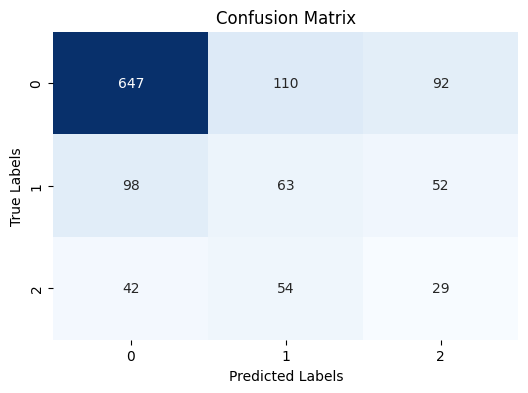


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 647/849 (76.21%)
Class 1: Correct Predictions / Total True Samples = 63/213 (29.58%)
Class 2: Correct Predictions / Total True Samples = 29/125 (23.20%)

Precision-Recall Curves:


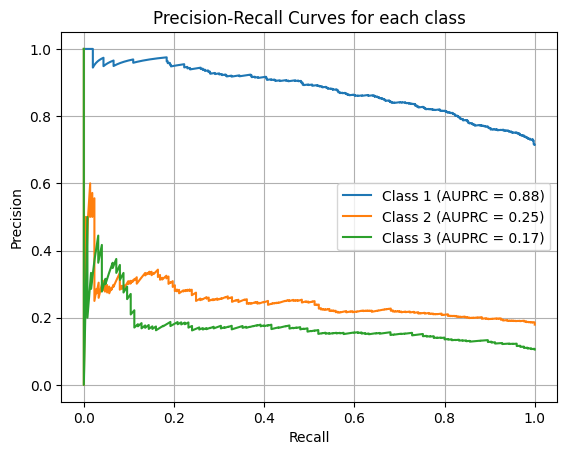


ROC Curves:


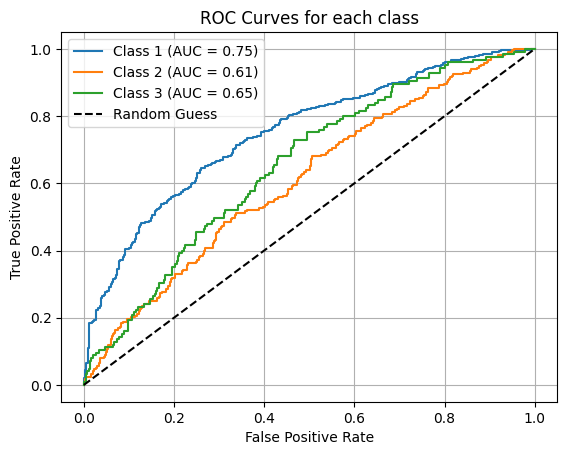


Mean F1 Score: 0.4240
Balanced Accuracy: 0.4299
Average AUPRC: 0.4331

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       849
           1       0.28      0.30      0.29       213
           2       0.17      0.23      0.19       125

    accuracy                           0.62      1187
   macro avg       0.42      0.43      0.42      1187
weighted avg       0.66      0.62      0.64      1187

Fold No: 5
Epoch [1/100], Loss: 1.1224, Accuracy: 0.3794
Validation Loss: 1.1393, Validation Accuracy: 0.3684
Epoch [2/100], Loss: 1.0818, Accuracy: 0.4247
Validation Loss: 1.0940, Validation Accuracy: 0.3738
Epoch [3/100], Loss: 1.0425, Accuracy: 0.5095
Validation Loss: 0.9583, Validation Accuracy: 0.4118
Epoch [4/100], Loss: 1.0299, Accuracy: 0.5461
Validation Loss: 0.9779, Validation Accuracy: 0.4260
Epoch [5/100], Loss: 1.0085, Accuracy: 0.5694
Validation Loss: 0.9294, Validation Accuracy: 0.4211
Epoch [6/100], Los

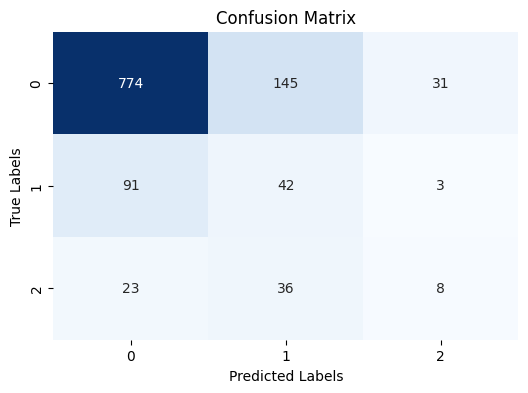


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 774/950 (81.47%)
Class 1: Correct Predictions / Total True Samples = 42/136 (30.88%)
Class 2: Correct Predictions / Total True Samples = 8/67 (11.94%)

Precision-Recall Curves:


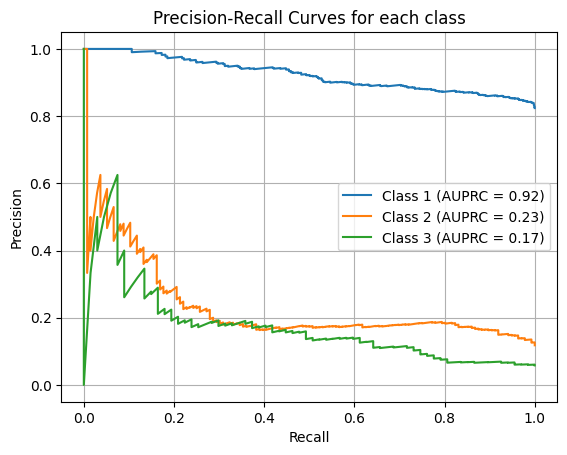


ROC Curves:


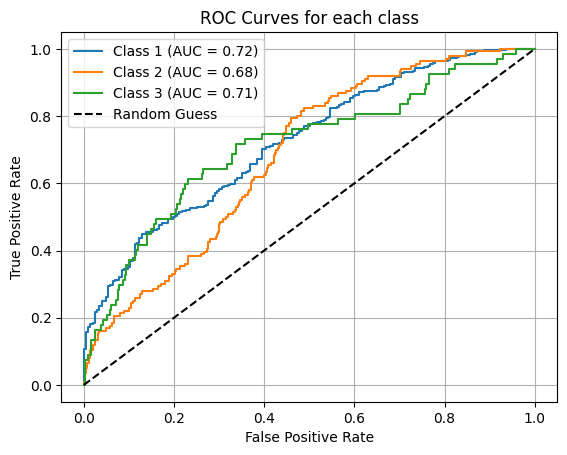


Mean F1 Score: 0.4077
Balanced Accuracy: 0.4143
Average AUPRC: 0.4410

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       950
           1       0.19      0.31      0.23       136
           2       0.19      0.12      0.15        67

    accuracy                           0.71      1153
   macro avg       0.42      0.41      0.41      1153
weighted avg       0.75      0.71      0.73      1153

Accuracy for each fold: [np.float64(0.5169274571729351), np.float64(0.4839930039041611), np.float64(0.5351551956815115), np.float64(0.4299492249926729), np.float64(0.4143211188638849)]
AUPRC for each fold: [np.float64(0.4934942881871625), np.float64(0.5072535717078616), np.float64(0.5230131767975482), np.float64(0.4331050644379999), np.float64(0.4410440958525235)]
Average AUPRC across all folds: 0.4795820393966192
Average Balanced Accuracy across all folds: 0.4760692001230331
___________________________________________

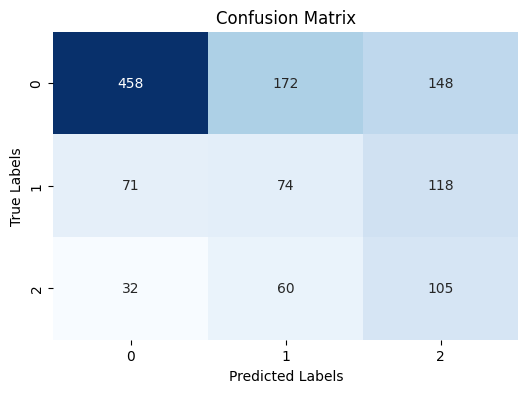


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 458/778 (58.87%)
Class 1: Correct Predictions / Total True Samples = 74/263 (28.14%)
Class 2: Correct Predictions / Total True Samples = 105/197 (53.30%)

Precision-Recall Curves:


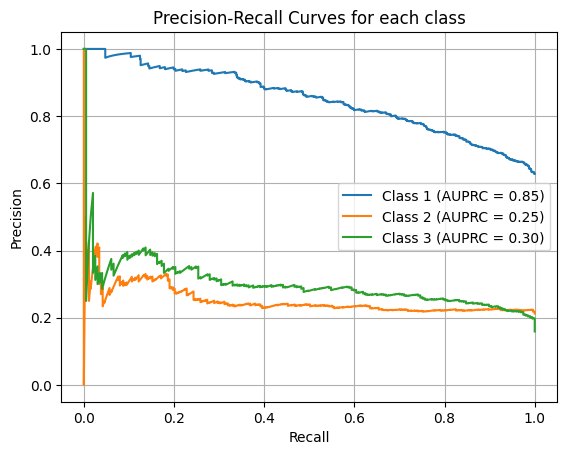


ROC Curves:


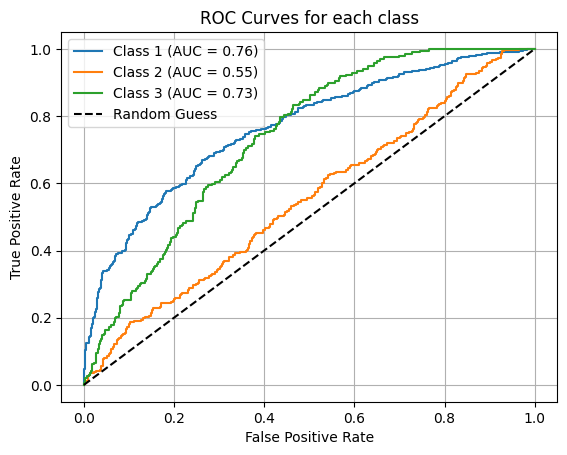


Mean F1 Score: 0.4380
Balanced Accuracy: 0.4677
Average AUPRC: 0.4654

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.59      0.68       778
           1       0.24      0.28      0.26       263
           2       0.28      0.53      0.37       197

    accuracy                           0.51      1238
   macro avg       0.45      0.47      0.44      1238
weighted avg       0.61      0.51      0.54      1238

Fold No: 2
Epoch [1/100], Loss: 1.1102, Accuracy: 0.3354
Validation Loss: 1.1190, Validation Accuracy: 0.4107
Epoch [2/100], Loss: 1.0960, Accuracy: 0.3875
Validation Loss: 1.1166, Validation Accuracy: 0.3581
Epoch [3/100], Loss: 1.1009, Accuracy: 0.3466
Validation Loss: 1.0707, Validation Accuracy: 0.3573
Epoch [4/100], Loss: 1.0908, Accuracy: 0.4110
Validation Loss: 1.1116, Validation Accuracy: 0.4094
Epoch [5/100], Loss: 1.0879, Accuracy: 0.4151
Validation Loss: 1.0948, Validation Accuracy: 0.4064
Epoch [6/100], Los

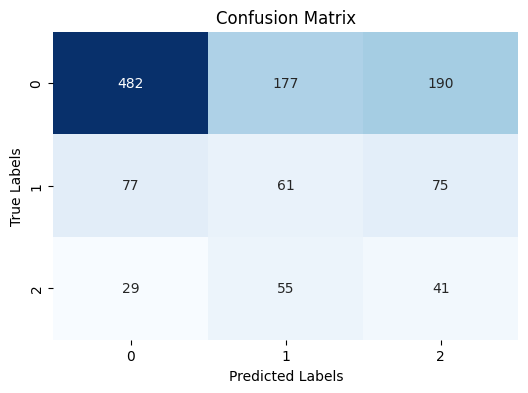


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 482/849 (56.77%)
Class 1: Correct Predictions / Total True Samples = 61/213 (28.64%)
Class 2: Correct Predictions / Total True Samples = 41/125 (32.80%)

Precision-Recall Curves:


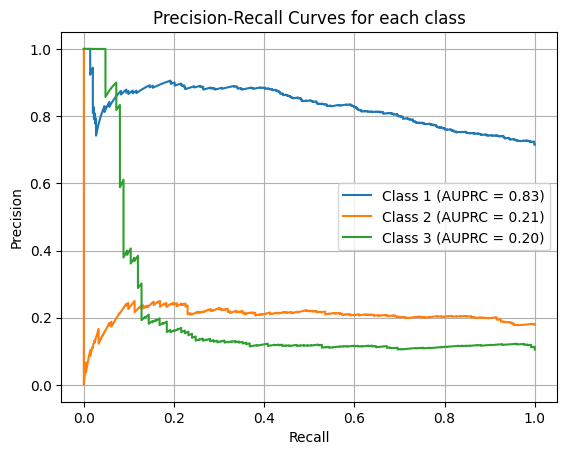


ROC Curves:


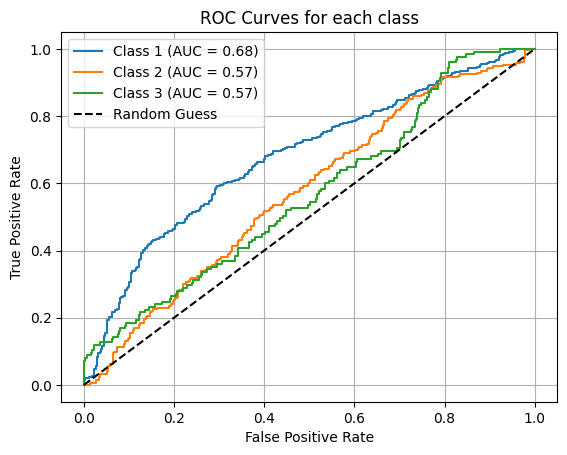


Mean F1 Score: 0.3674
Balanced Accuracy: 0.3940
Average AUPRC: 0.4135

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       849
           1       0.21      0.29      0.24       213
           2       0.13      0.33      0.19       125

    accuracy                           0.49      1187
   macro avg       0.39      0.39      0.37      1187
weighted avg       0.64      0.49      0.54      1187

Fold No: 3
Epoch [1/100], Loss: 1.1055, Accuracy: 0.3494
Validation Loss: 1.1673, Validation Accuracy: 0.2939
Epoch [2/100], Loss: 1.0967, Accuracy: 0.4042
Validation Loss: 1.1094, Validation Accuracy: 0.3482
Epoch [3/100], Loss: 1.0912, Accuracy: 0.4101
Validation Loss: 1.0567, Validation Accuracy: 0.3549
Epoch [4/100], Loss: 1.0828, Accuracy: 0.4225
Validation Loss: 1.1588, Validation Accuracy: 0.3255
Epoch [5/100], Loss: 1.0742, Accuracy: 0.4532
Validation Loss: 1.0546, Validation Accuracy: 0.3661
Epoch [6/100], Los

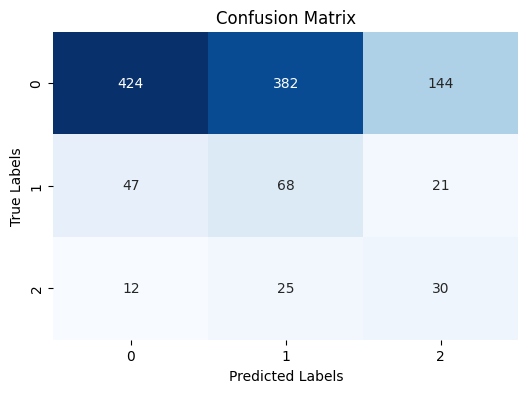


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 424/950 (44.63%)
Class 1: Correct Predictions / Total True Samples = 68/136 (50.00%)
Class 2: Correct Predictions / Total True Samples = 30/67 (44.78%)

Precision-Recall Curves:


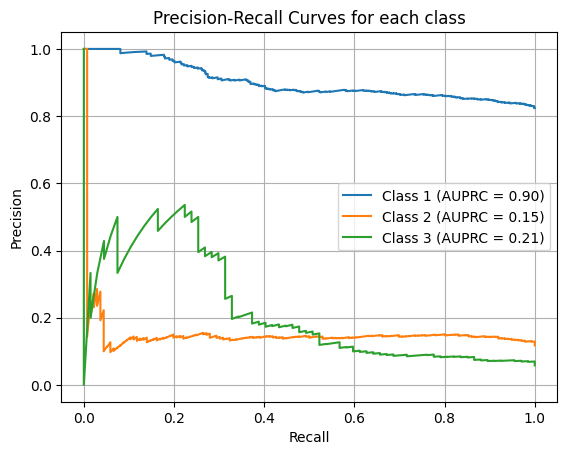


ROC Curves:


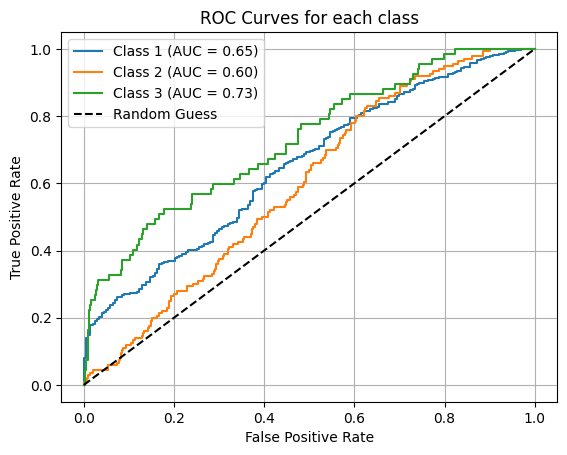


Mean F1 Score: 0.3478
Balanced Accuracy: 0.4647
Average AUPRC: 0.4213

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.45      0.59       950
           1       0.14      0.50      0.22       136
           2       0.15      0.45      0.23        67

    accuracy                           0.45      1153
   macro avg       0.39      0.46      0.35      1153
weighted avg       0.75      0.45      0.53      1153

Fold No: 4
Epoch [1/100], Loss: 1.1069, Accuracy: 0.3422
Validation Loss: 1.1365, Validation Accuracy: 0.4443
Epoch [2/100], Loss: 1.0997, Accuracy: 0.3666
Validation Loss: 1.1270, Validation Accuracy: 0.4098
Epoch [3/100], Loss: 1.0977, Accuracy: 0.3762
Validation Loss: 1.0879, Validation Accuracy: 0.4270
Epoch [4/100], Loss: 1.0892, Accuracy: 0.4028
Validation Loss: 1.0513, Validation Accuracy: 0.4277
Epoch [5/100], Loss: 1.0915, Accuracy: 0.3976
Validation Loss: 1.0004, Validation Accuracy: 0.3454
Epoch [6/100], Los

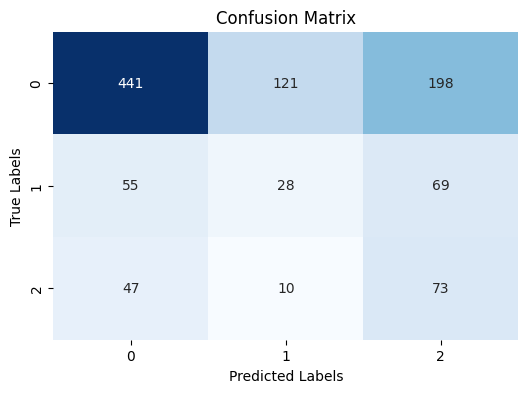


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 441/760 (58.03%)
Class 1: Correct Predictions / Total True Samples = 28/152 (18.42%)
Class 2: Correct Predictions / Total True Samples = 73/130 (56.15%)

Precision-Recall Curves:


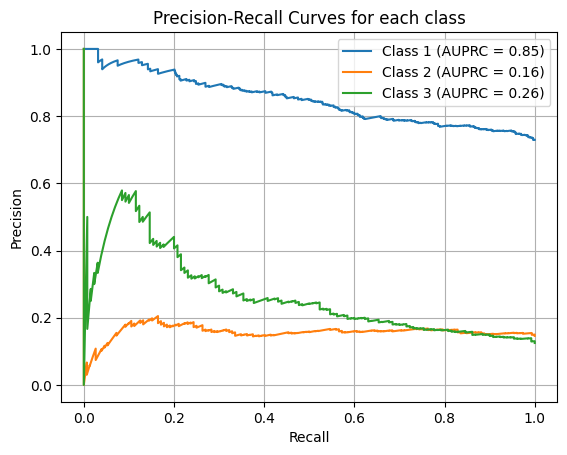


ROC Curves:


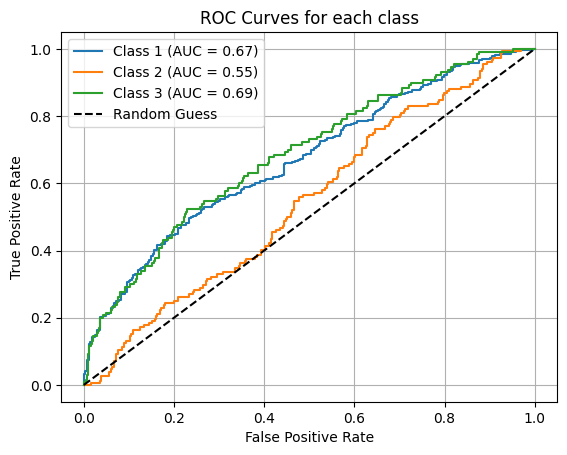


Mean F1 Score: 0.3892
Balanced Accuracy: 0.4420
Average AUPRC: 0.4222

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.58      0.68       760
           1       0.18      0.18      0.18       152
           2       0.21      0.56      0.31       130

    accuracy                           0.52      1042
   macro avg       0.40      0.44      0.39      1042
weighted avg       0.64      0.52      0.56      1042

Fold No: 5
Epoch [1/100], Loss: 1.1095, Accuracy: 0.3333
Validation Loss: 1.0712, Validation Accuracy: 0.3180
Epoch [2/100], Loss: 1.1040, Accuracy: 0.3513
Validation Loss: 1.1248, Validation Accuracy: 0.3268
Epoch [3/100], Loss: 1.0967, Accuracy: 0.3659
Validation Loss: 1.0721, Validation Accuracy: 0.3335
Epoch [4/100], Loss: 1.0951, Accuracy: 0.3805
Validation Loss: 1.0877, Validation Accuracy: 0.3645
Epoch [5/100], Loss: 1.0867, Accuracy: 0.3933
Validation Loss: 1.1138, Validation Accuracy: 0.3942
Epoch [6/100], Los

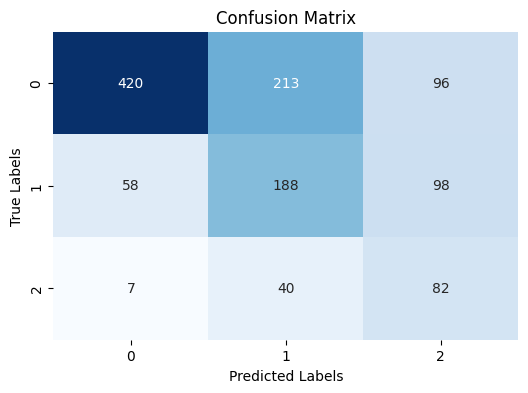


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 420/729 (57.61%)
Class 1: Correct Predictions / Total True Samples = 188/344 (54.65%)
Class 2: Correct Predictions / Total True Samples = 82/129 (63.57%)

Precision-Recall Curves:


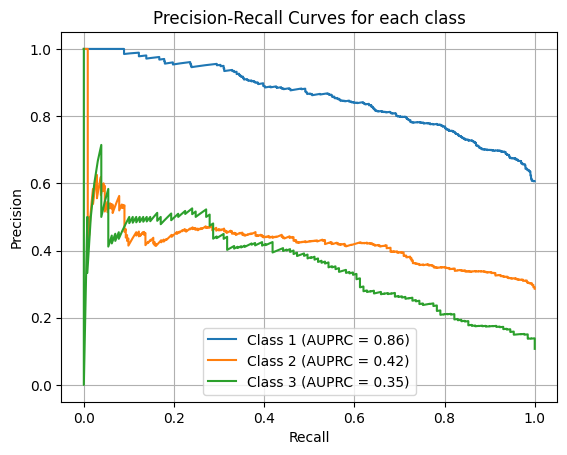


ROC Curves:


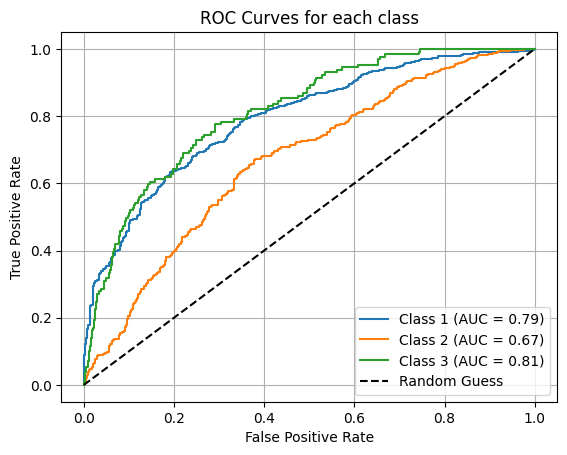


Mean F1 Score: 0.5253
Balanced Accuracy: 0.5861
Average AUPRC: 0.5442

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.58      0.69       729
           1       0.43      0.55      0.48       344
           2       0.30      0.64      0.40       129

    accuracy                           0.57      1202
   macro avg       0.53      0.59      0.53      1202
weighted avg       0.68      0.57      0.60      1202

Accuracy for each fold: [np.float64(0.4676842303886894), np.float64(0.39403723795462214), np.float64(0.46469232783451164), np.float64(0.44200404858299597), np.float64(0.5861007432928191)]
AUPRC for each fold: [np.float64(0.46536528106971514), np.float64(0.41349506704861055), np.float64(0.4213478384364882), np.float64(0.42223480678411246), np.float64(0.5442449556562899)]
Average AUPRC across all folds: 0.45333758979904326
Average Balanced Accuracy across all folds: 0.4709037176107277
____________________________________

In [9]:
import pandas as pd
import os
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
        {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 4.791527211534685e-05, 'weight_decay': 2.723389186594195e-05, 'batch_size': 32, 'num_transformer_blocks': 6, 'num_heads': 8, 'accuracy': 0.4340},
    {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 5.5832423292191354e-05, 'weight_decay': 7.139534466914747e-05, 'batch_size': 32, 'num_transformer_blocks': 8, 'num_heads': 8, 'accuracy': 0.4309},
    {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 2.0947119755454103e-05, 'weight_decay': 1.0971600691032106e-05, 'batch_size': 32, 'num_transformer_blocks': 4, 'num_heads': 8, 'accuracy': 0.4271},
    {'n_patches': 28, 'embed_dim': 256, 'learning_rate': 0.00010639460520943286, 'weight_decay': 9.127612419083566e-05, 'batch_size': 32, 'num_transformer_blocks': 2, 'num_heads': 8, 'accuracy': 0.4145},
    {'n_patches': 14, 'embed_dim': 64, 'learning_rate': 1.2342942482714458e-05, 'weight_decay': 2.3932751754652317e-05, 'batch_size': 32, 'num_transformer_blocks': 4, 'num_heads': 8, 'accuracy': 0.4140}

]

for param_id in range(len(top_params)):
    
    print(f"Running experiment with parameters: {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3

    epochs = 100
    input_shape = (3, 224,224)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    n_patches = top_params[param_id]['n_patches']
    hidden_size = top_params[param_id]['embed_dim']
    num_transformer_blocks = top_params[param_id]['num_transformer_blocks']
    weight_decay = top_params[param_id]['weight_decay']
    num_heads = top_params[param_id]['num_heads']
    learning_rate = top_params[param_id]['learning_rate']
    factor = 1
    batch_size = top_params[param_id]['batch_size']

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        




    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = vit(
            input_size=input_shape, 
            n_patches=n_patches, 
            hidden_size=hidden_size, 
            num_classes=num_classes,
            num_transformer_blocks=num_transformer_blocks,
            num_heads=num_heads
        ).to(device)
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')


    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    

